In [248]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#(Daily % of underlying total return index) * X - ER/250 - (X - 1) * (1 month LIBOR) * 
#(Current date - previous date)/360

######

#TODO: Resolve Look Ahead Bias


#######

start_date = "1986-01-01"
start_date_extra = "1985-12-31"
##start_date = "2010-01-03"
#start_date_extra = "2010-01-02"
end_date = "2021-10-01"
expense_ratio = 0.000945
leverage = 1


df_libor = pd.read_csv("USD1MTD156N.csv")
df_libor.rename(columns={"DATE":"Date", "USD1MTD156N":"Value"}, inplace=True)
df_libor.set_index("Date",  inplace=True)
df_libor.index = pd.to_datetime(df_libor.index)
df_libor = df_libor[df_libor.Value != '.']
df_libor = df_libor.loc[start_date_extra:end_date]
df_libor.Value = pd.to_numeric(df_libor.Value)
#df_libor.USD1MTD156N = pd.to_numeric(df_libor.USD1MTD156N)
#df_libor.DATE = pd.to_datetime(df_libor.DATE)
df_tqqq_real = pd.read_csv("SPY.csv", index_col = "Date")
df_tqqq_real = df_tqqq_real.loc[start_date:end_date]
df_tqqq_real.index = pd.to_datetime(df_tqqq_real.index)
#print(df_tqqq_real)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

    df_ndq = pd.read_excel("SPX.xlsx")
    df_ndq["Date"] = df_ndq["Date"].dt.date
    df_ndq.set_index("Date", inplace=True)
    df_ndq.index = pd.to_datetime(df_ndq.index)
    df_ndq = df_ndq.loc[start_date_extra:end_date]
    
    df_ndq = df_ndq.loc[df_ndq.index.isin(df_libor.index)]
    df_libor = df_libor.loc[df_libor.index.isin(df_ndq.index)]
    returns_close = pd.DataFrame(df_ndq["Close"].pct_change(1))
    returns_close = returns_close.loc[returns_close.index.isin(df_libor.index)]
    
    returns_open = pd.DataFrame(df_ndq["Open"].pct_change(1))
    returns_open = returns_open.loc[returns.index.isin(df_libor.index)]
    
    returns_low = pd.DataFrame(df_ndq["Low"].pct_change(1))
    returns_low = returns_low.loc[returns.index.isin(df_libor.index)]
    
    returns_high = pd.DataFrame(df_ndq["High"].pct_change(1))
    returns_high = returns_high.loc[returns.index.isin(df_libor.index)]
    
    dates = df_ndq.index
    datesdiff = pd.DataFrame((dates[1:] - dates[:-1])/np.timedelta64(1, "D"));
    datesdiff.index = df_ndq[1:].index;



In [249]:
df_tqqq_sim_close = pd.DataFrame((returns_close["Close"][1:] * leverage) - expense_ratio/250 - ((leverage - 1) * df_libor["Value"][1:]/100 * (datesdiff["Date"]/360)), columns=["Close"])
df_tqqq_sim_close = df_tqqq_sim_close.loc[df_tqqq_sim_close.index.isin(df_libor.index)]

df_tqqq_sim_open = pd.DataFrame((returns_open["Open"][1:] * leverage) - expense_ratio/250 - ((leverage - 1) * df_libor["Value"][1:]/100 * (datesdiff["Date"]/360)), columns=["Open"])
df_tqqq_sim_open = df_tqqq_sim_open.loc[df_tqqq_sim_open.index.isin(df_libor.index)]

df_tqqq_sim_low = pd.DataFrame((returns_low["Low"][1:] * leverage) - expense_ratio/250 - ((leverage - 1) * df_libor["Value"][1:]/100 * (datesdiff["Date"]/360)), columns=["Low"])
df_tqqq_sim_low = df_tqqq_sim_low.loc[df_tqqq_sim_low.index.isin(df_libor.index)]

df_tqqq_sim_high = pd.DataFrame((returns_high["High"][1:] * leverage) - expense_ratio/250 - ((leverage - 1) * df_libor["Value"][1:]/100 * (datesdiff["Date"]/360)), columns=["High"])
df_tqqq_sim_high = df_tqqq_sim_high.loc[df_tqqq_sim_high.index.isin(df_libor.index)]



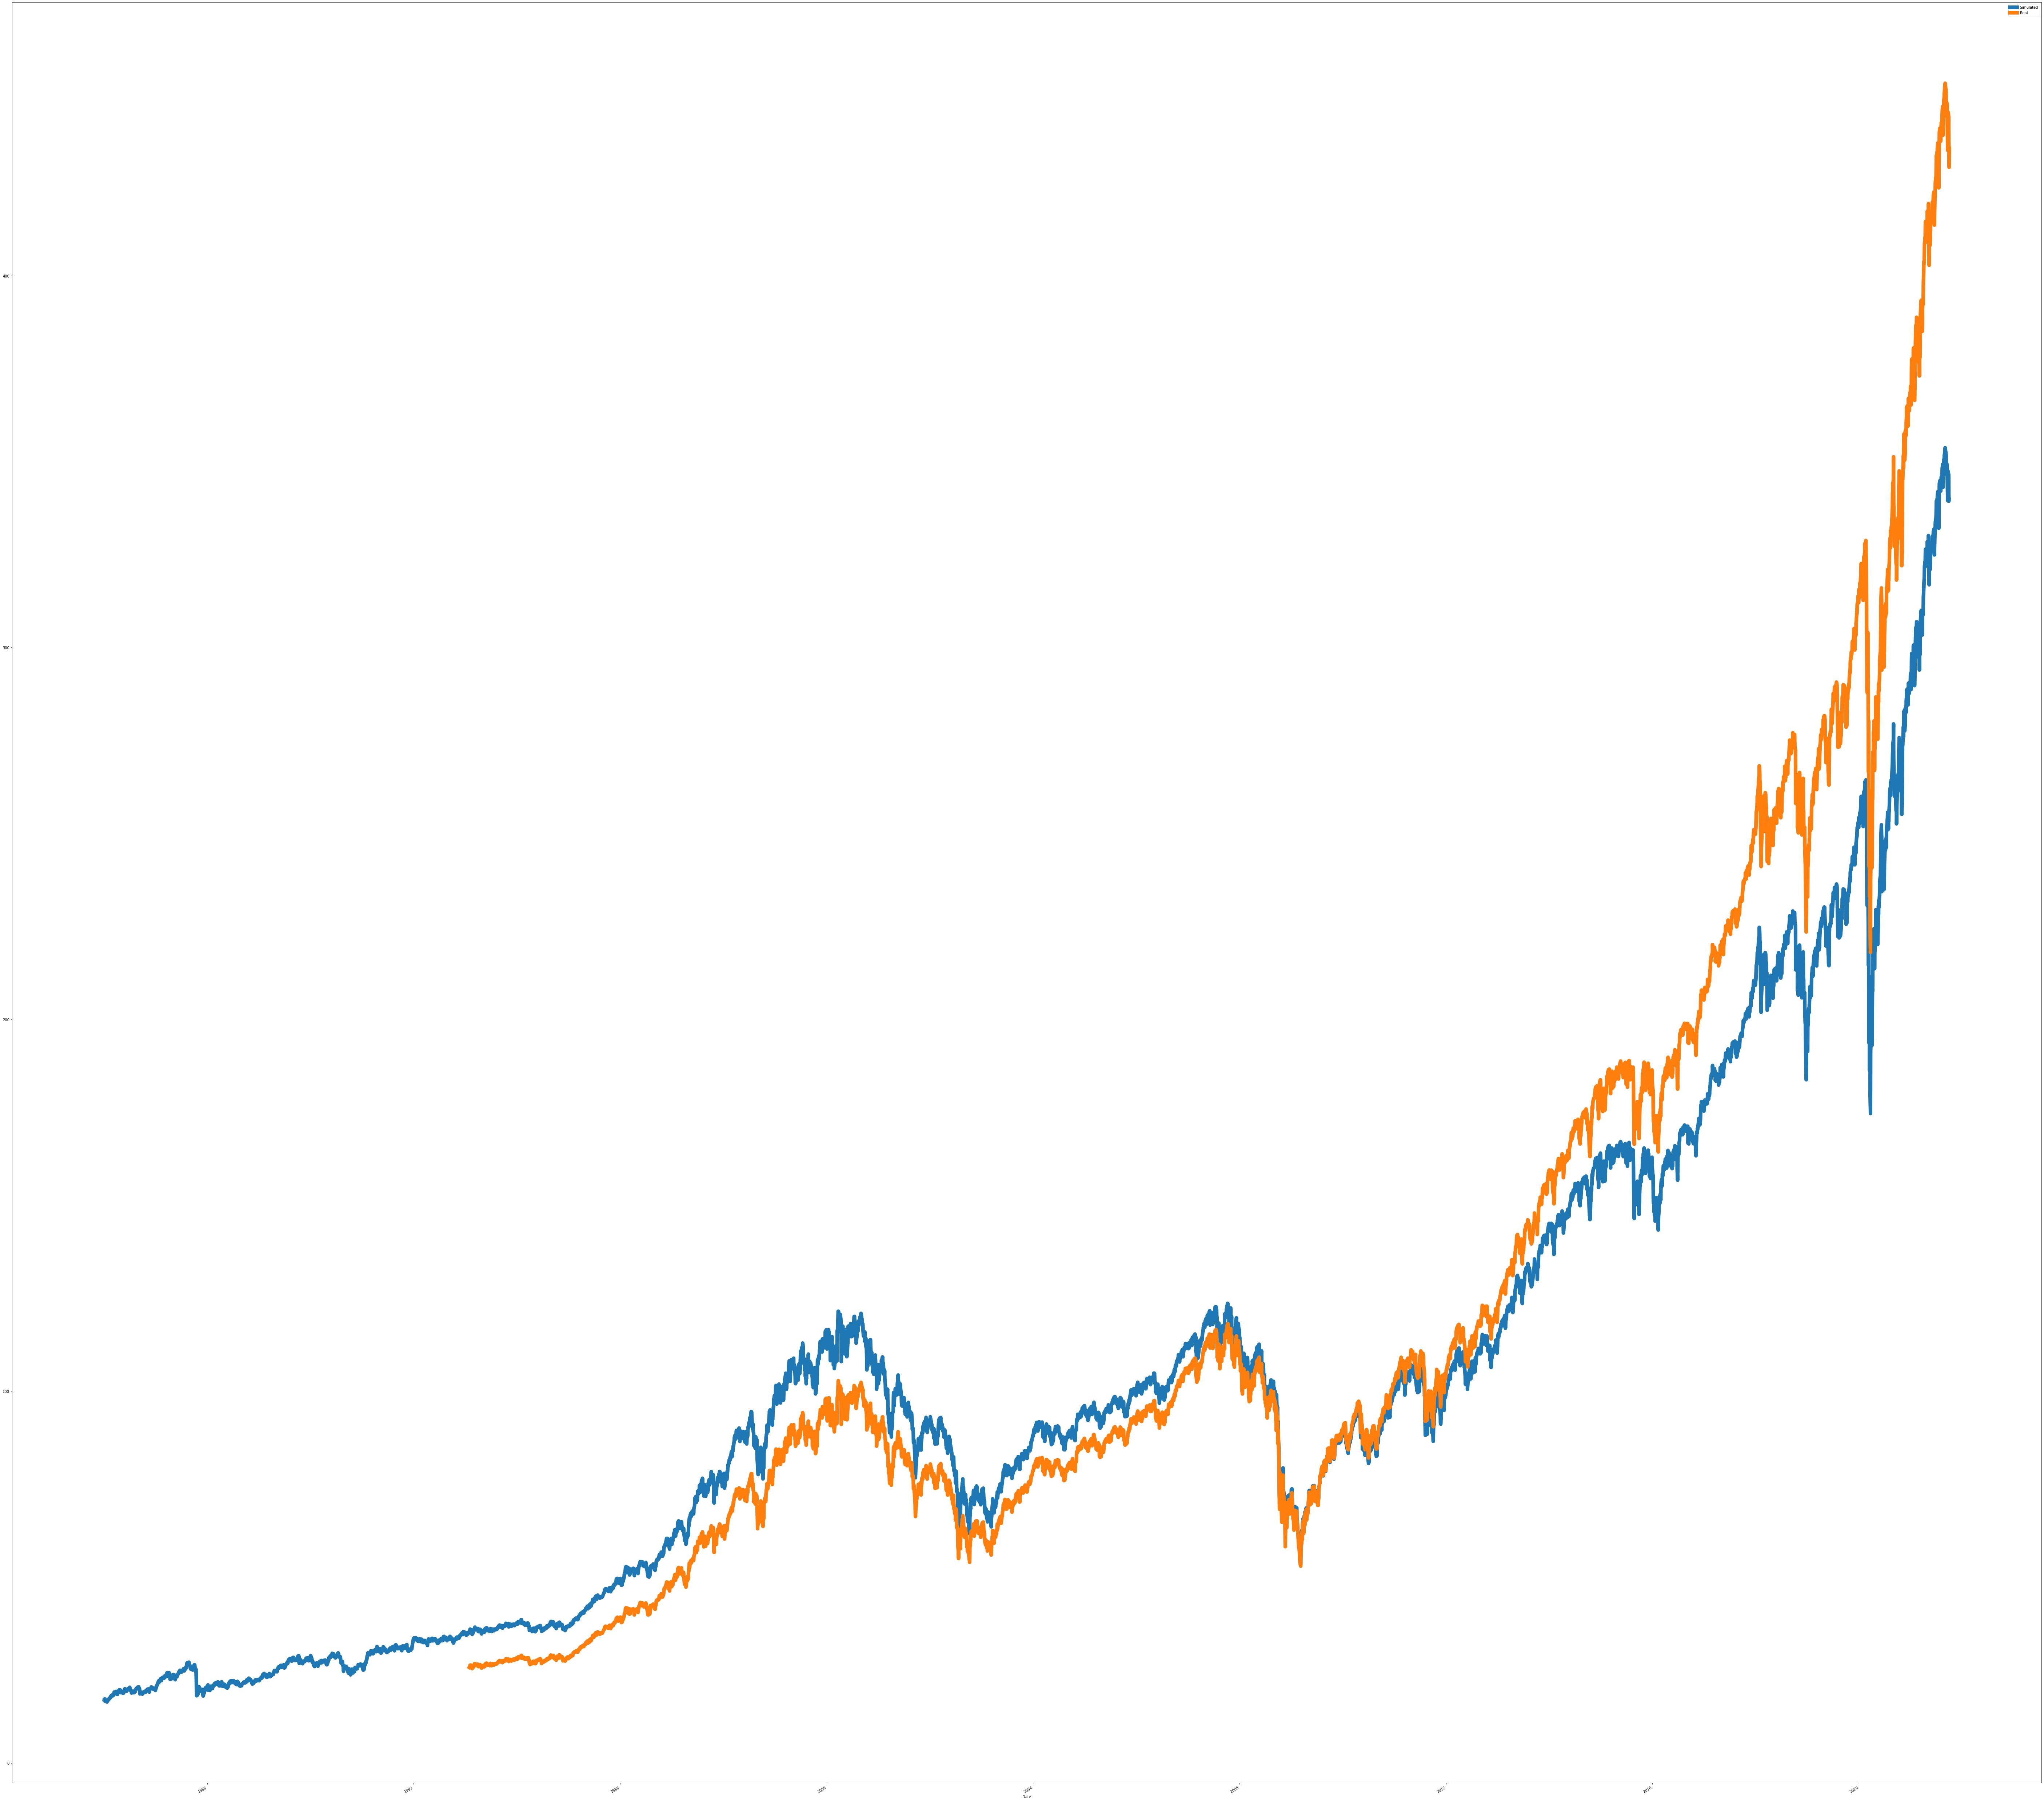

In [250]:
def compound_return(etf: pd.DataFrame, starting_amount: float = 1.0, base_col: str = 'Close') -> pd.DataFrame:
    total_val = starting_amount
    df = pd.DataFrame(index=etf.index)
    df.loc[df.iloc[0], 'sim'+base_col] = total_val

    row_idx = 0
    for index, _ in df.iterrows():
        if row_idx != 0:
            total_val = total_val + total_val * etf.loc[index, base_col]

        # df.at[index, 'Investment'] = total_val
        df.loc[index, 'sim'+base_col] = total_val
        row_idx += 1

    return df

df_tqqq_sim_compound_close = compound_return(df_tqqq_sim_close, starting_amount=17);
tqqq_graph = df_tqqq_sim_compound_close["simClose"]
tqqq_graph.plot(legend=True, label="Simulated", figsize=(100,100), lw=10)
tqqq_real = df_tqqq_real["Close"];
tqqq_real.plot(legend=True, label="Real",  figsize=(100,100), lw=10);

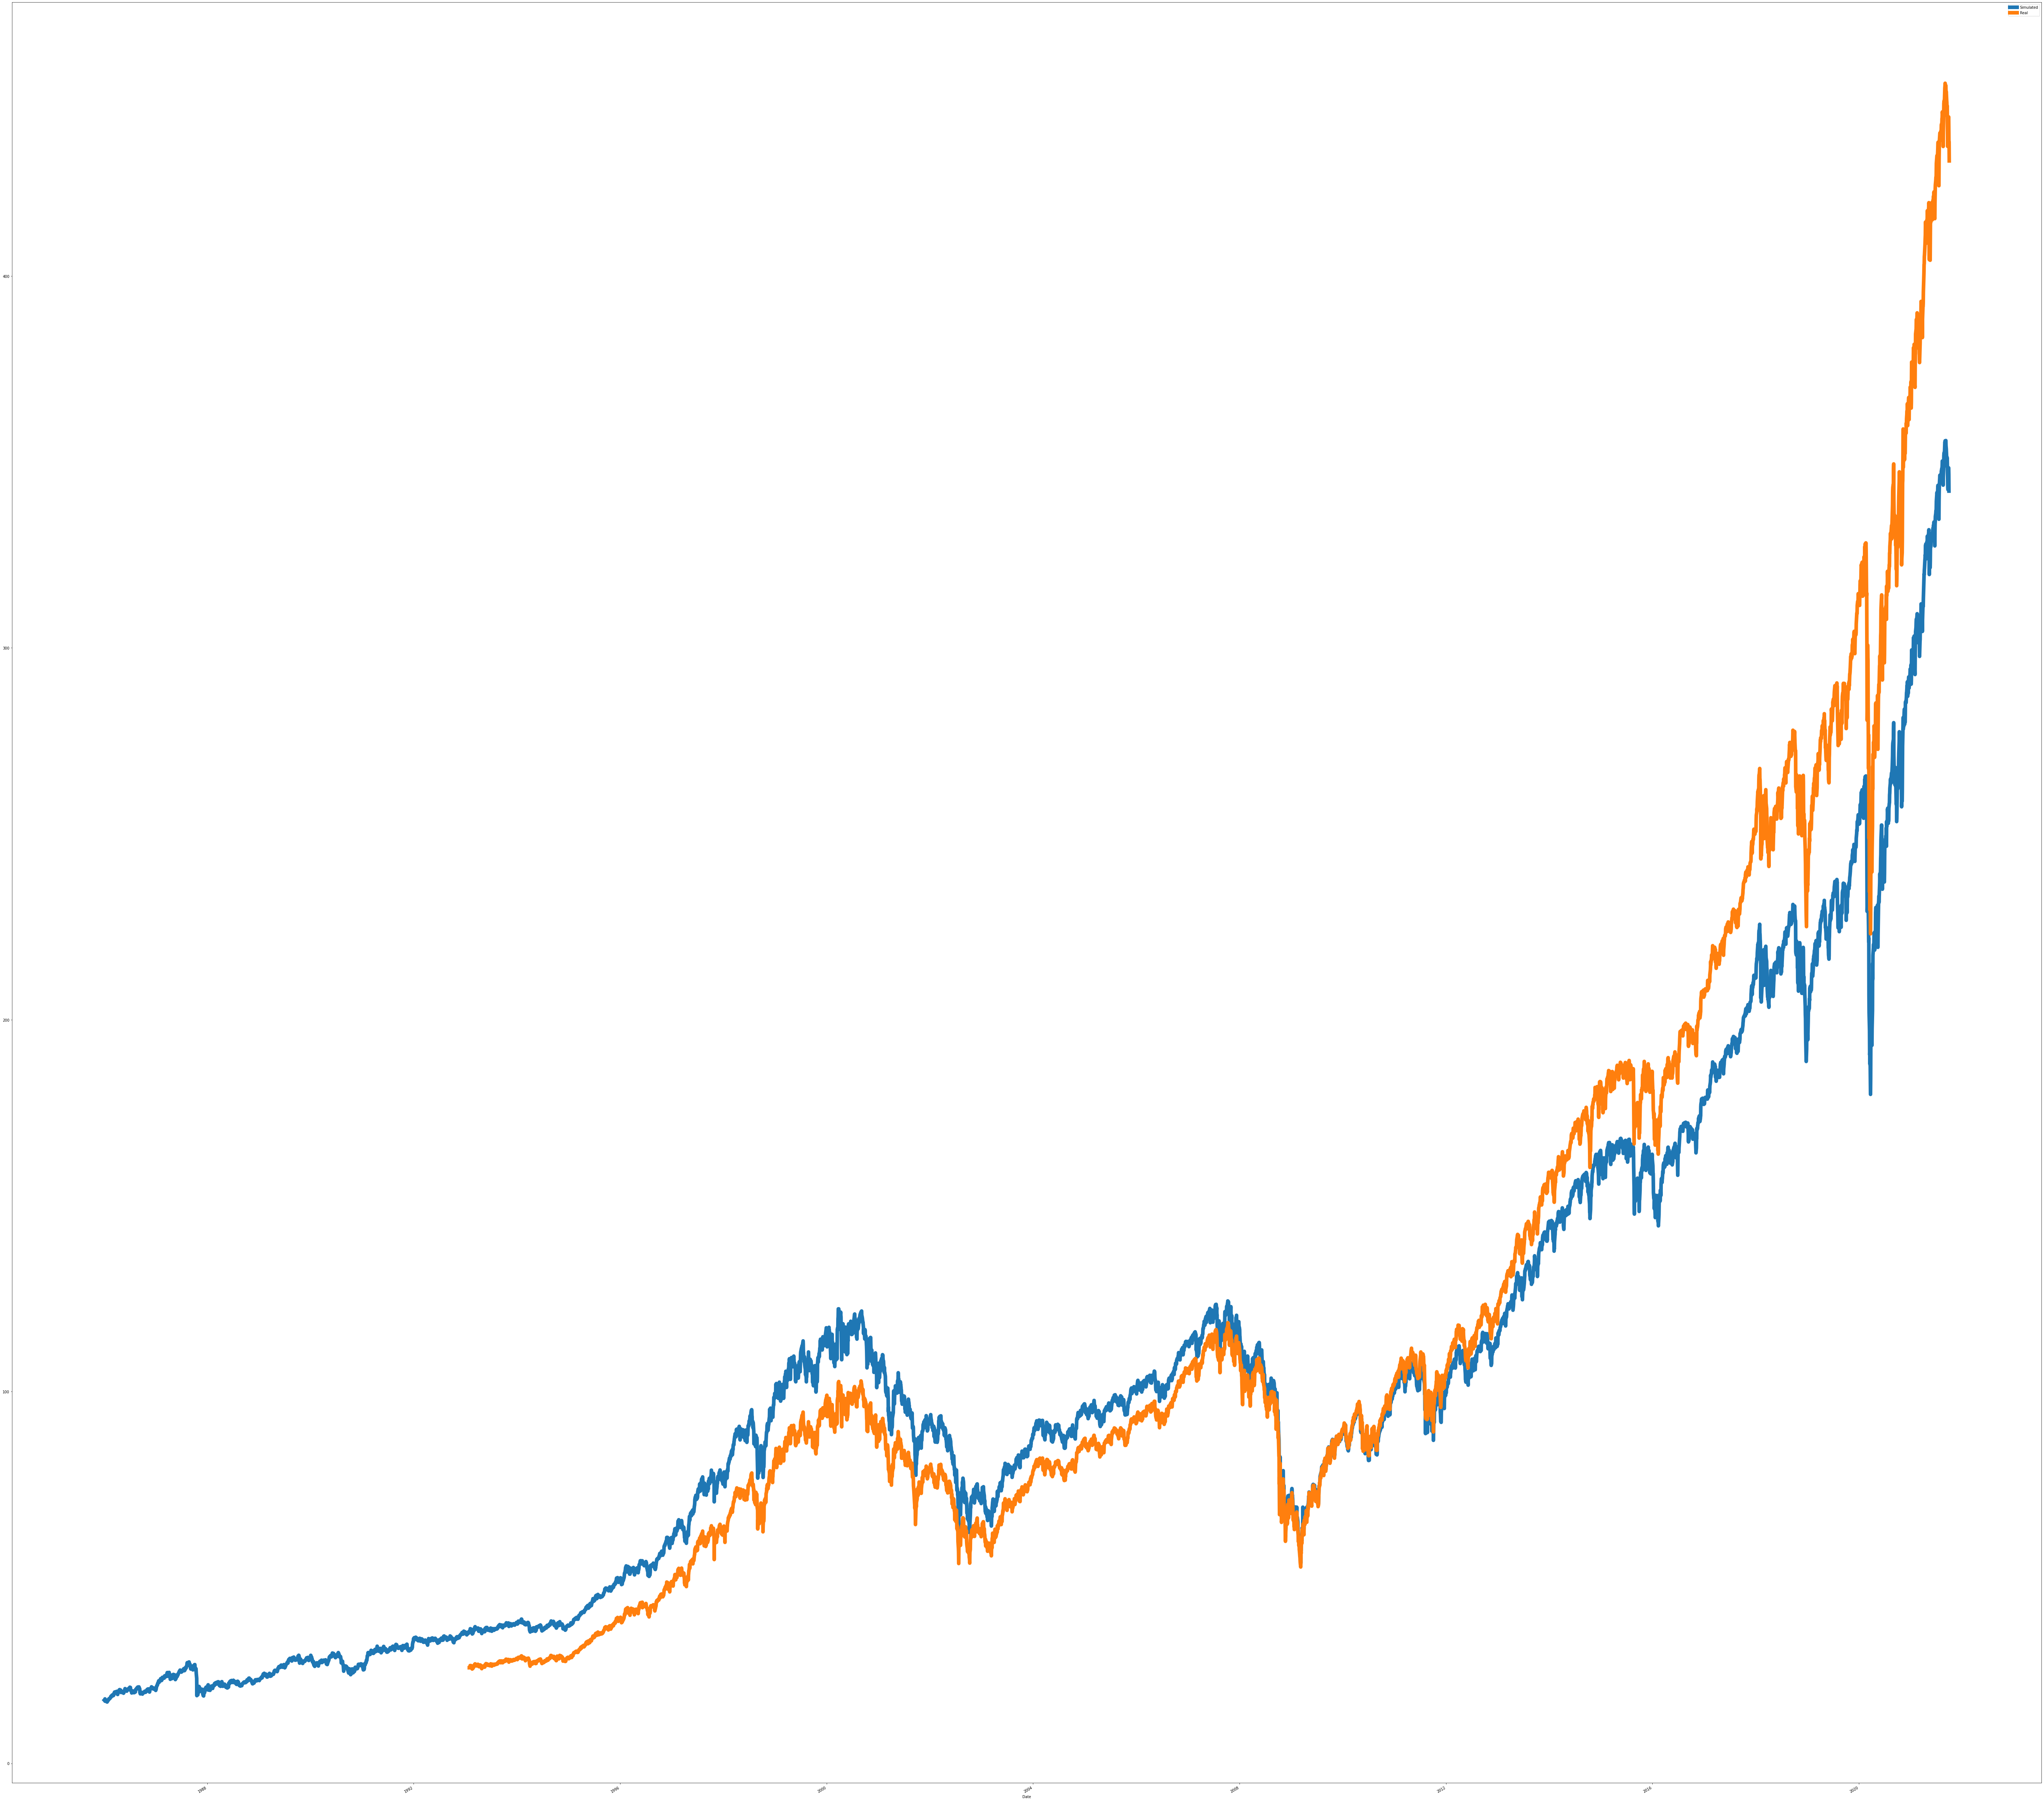

In [251]:
df_tqqq_sim_compound_open = compound_return(df_tqqq_sim_open, starting_amount=17, base_col="Open");
tqqq_graph = df_tqqq_sim_compound_open["simOpen"]
tqqq_graph.plot(legend=True, label="Simulated", figsize=(100,100), lw=10)
tqqq_real = df_tqqq_real["Open"];
tqqq_real.plot(legend=True, label="Real",  figsize=(100,100), lw=10);

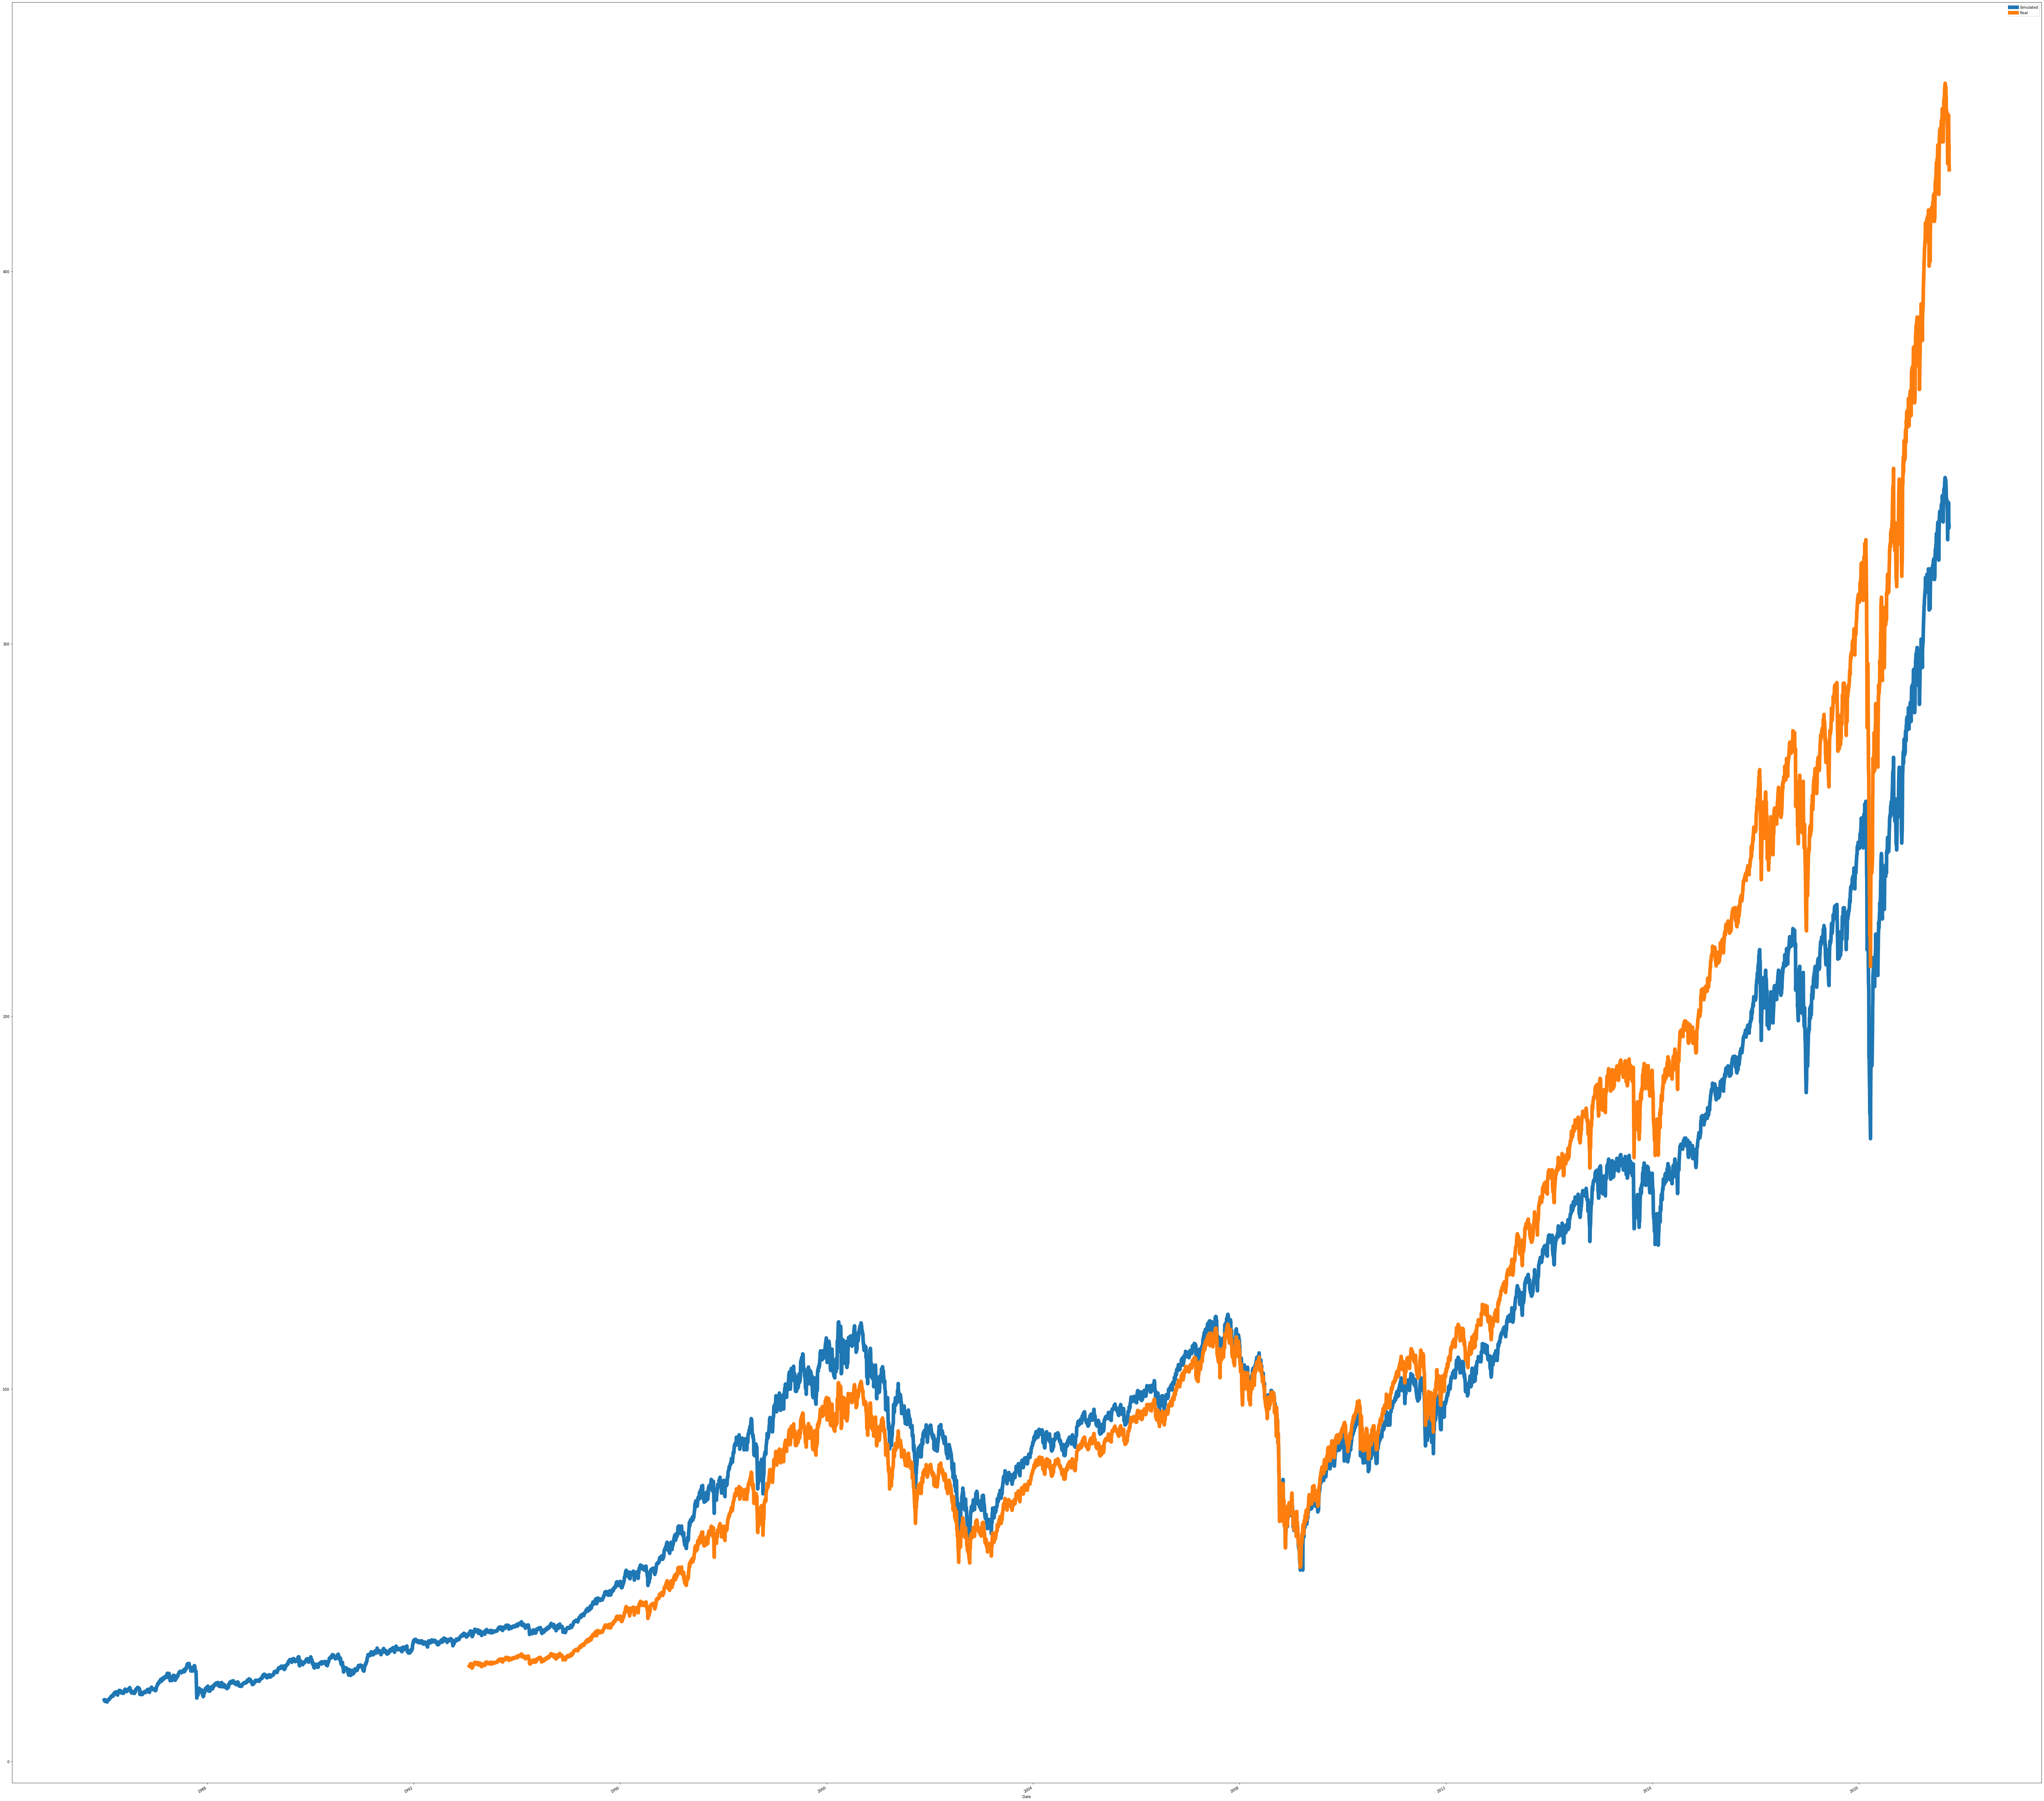

In [252]:
df_tqqq_sim_compound_low = compound_return(df_tqqq_sim_low, starting_amount=16.5, base_col="Low");
tqqq_graph = df_tqqq_sim_compound_low["simLow"]
tqqq_graph.plot(legend=True, label="Simulated", figsize=(100,100), lw=10)
tqqq_real = df_tqqq_real["Low"];
tqqq_real.plot(legend=True, label="Real",  figsize=(100,100), lw=10);

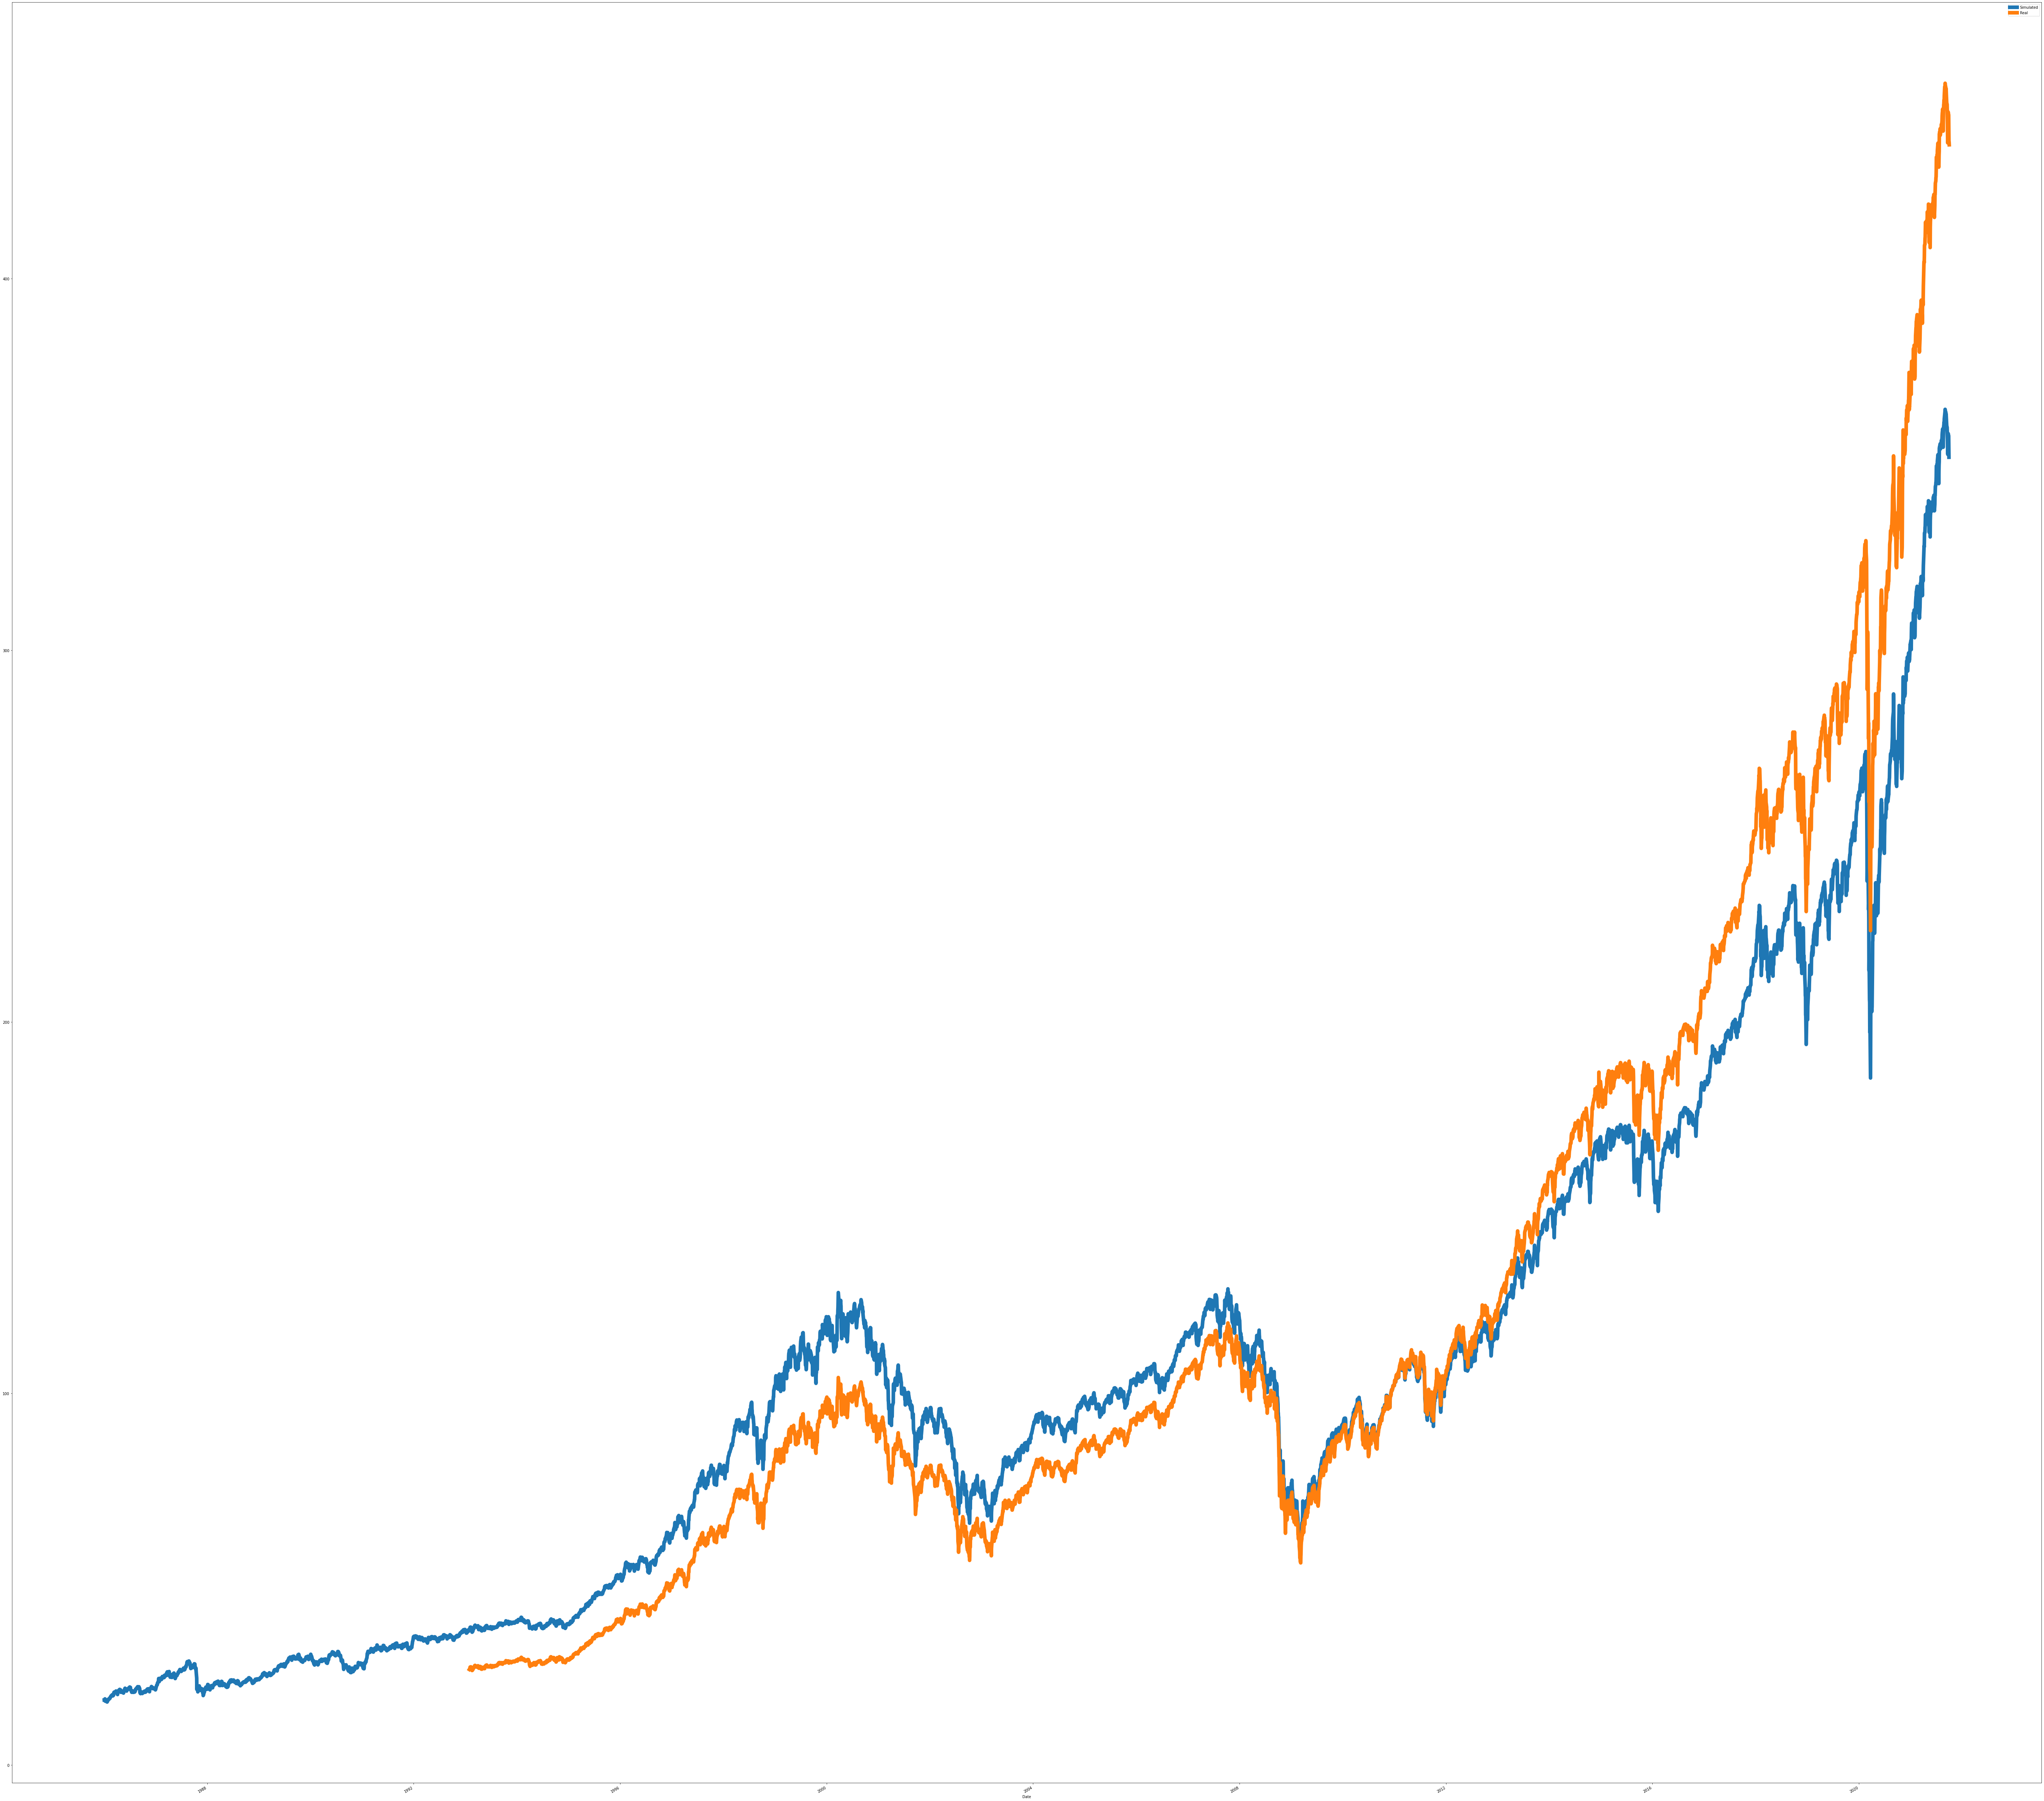

In [253]:
df_tqqq_sim_compound_high = compound_return(df_tqqq_sim_high, starting_amount=17.5, base_col="High");
tqqq_graph = df_tqqq_sim_compound_high["simHigh"]
tqqq_graph.plot(legend=True, label="Simulated", figsize=(100,100), lw=10)
tqqq_real = df_tqqq_real["High"];
tqqq_real.plot(legend=True, label="Real",  figsize=(100,100), lw=10);

In [254]:
df_final_sim = df_tqqq_sim_compound_open
df_final_sim["simHigh"] = df_tqqq_sim_compound_high["simHigh"]
df_final_sim["simLow"] = df_tqqq_sim_compound_low["simLow"]
df_final_sim["simClose"] = df_tqqq_sim_compound_close["simClose"]


delta = df_tqqq_sim_compound_close['simClose'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=14, adjust=False).mean()
ema_down = down.ewm(com=14, adjust=False).mean()
rs = ema_up/ema_down

df_final_sim['simRSI'] = 100 - (100/(1 + rs))
print(df_final_sim)


               simOpen     simHigh      simLow    simClose     simRSI
Date                                                                 
1986-01-03   17.000000   17.500000   16.500000   17.000000        NaN
1986-01-06   17.104569   17.508232   16.533015   16.981394   0.000000
1986-01-07   17.085849   17.742185   16.589656   17.235265  49.357653
1986-01-08   17.341281   17.806016   16.340729   16.765221  24.938959
1986-01-09   16.868345   17.258250   16.105979   16.615216  21.330668
...                ...         ...         ...         ...        ...
2021-09-23  345.660202  358.357058  335.621844  346.837876  50.588970
2021-09-24  348.113246  358.172729  337.424826  347.343298  51.456437
2021-09-27  348.431959  357.704311  337.861474  346.377636  49.671312
2021-09-28  346.659507  354.672668  331.016434  339.322653  39.063341
2021-09-29  342.177039  351.945200  331.681583  339.853824  40.095363

[8869 rows x 5 columns]


In [255]:

df_final_sim.drop(["1986-01-03", "1986-01-06"], inplace=True)
print(df_final_sim)

               simOpen     simHigh      simLow    simClose     simRSI
Date                                                                 
1986-01-07   17.085849   17.742185   16.589656   17.235265  49.357653
1986-01-08   17.341281   17.806016   16.340729   16.765221  24.938959
1986-01-09   16.868345   17.258250   16.105979   16.615216  21.330668
1986-01-10   16.717418   17.205075   16.185460   16.603061  21.066054
1986-01-13   16.705188   17.163518   16.185399   16.664264  26.017437
...                ...         ...         ...         ...        ...
2021-09-23  345.660202  358.357058  335.621844  346.837876  50.588970
2021-09-24  348.113246  358.172729  337.424826  347.343298  51.456437
2021-09-27  348.431959  357.704311  337.861474  346.377636  49.671312
2021-09-28  346.659507  354.672668  331.016434  339.322653  39.063341
2021-09-29  342.177039  351.945200  331.681583  339.853824  40.095363

[8867 rows x 5 columns]


In [256]:
df_final_sim.to_csv('simSPY.csv')

In [257]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

scaler = MinMaxScaler(feature_range=(-1, 1))
df_final_sim["simOpen"] = scaler.fit_transform(df_final_sim["simOpen"].values.reshape(-1,1))
df_final_sim["simClose"] = scaler.fit_transform(df_final_sim["simClose"].values.reshape(-1,1))
df_final_sim["simLow"] = scaler.fit_transform(df_final_sim["simLow"].values.reshape(-1,1))
df_final_sim["simHigh"] = scaler.fit_transform(df_final_sim["simHigh"].values.reshape(-1,1))
df_final_sim["simRSI"] = scaler.fit_transform(df_final_sim["simRSI"].values.reshape(-1,1))

df_vix_real = pd.read_csv("^VIX.csv")
df_vix_real["Date"] = pd.to_datetime(df_vix_real["Date"])
df_vix_real.set_index("Date", inplace=True)
df_vix_real = df_vix_real[start_date_extra:end_date]
print(df_vix_real)
df_vix_real = df_vix_real.loc[df_vix_real.index.isin(df_final_sim.index)]
df_vix_real.drop(columns = ["Adj Close", "Volume"], inplace=True)
df_vix_real = df_vix_real.div(100.0)
'''
df_vix_scaled = df_vix_real
df_vix_scaled["Open"] = scaler.fit_transform(df_vix_scaled["Open"].values.reshape(-1,1))
df_vix_scaled["Close"] = scaler.fit_transform(df_vix_scaled["High"].values.reshape(-1,1))
df_vix_scaled["Low"] = scaler.fit_transform(df_vix_scaled["Low"].values.reshape(-1,1))
df_vix_scaled["High"] = scaler.fit_transform(df_vix_scaled["Close"].values.reshape(-1,1))
'''
print(df_vix_real)
vix = df_vix_real.to_numpy()
vix = torch.from_numpy(vix).type(torch.Tensor)
print(vix)

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2003-09-23  19.910000  19.969999  19.309999  19.469999  19.469999       0
2003-09-24  19.530001  21.260000  19.440001  21.219999  21.219999       0
2003-09-25  21.110001  22.270000  21.040001  22.260000  22.260000       0
2003-09-26  22.280001  22.730000  21.850000  22.230000  22.230000       0
2003-09-29  22.850000  22.850000  21.639999  21.670000  21.670000       0
...               ...        ...        ...        ...        ...     ...
2021-09-27  17.780001  19.320000  17.740000  18.760000  18.760000       0
2021-09-28  19.740000  24.820000  19.709999  23.250000  23.250000       0
2021-09-29  22.070000  23.790001  21.450001  22.559999  22.559999       0
2021-09-30  21.480000  24.709999  20.600000  23.139999  23.139999       0
2021-10-01  24.780001  24.889999  20.850000  21.100000  21.100000       0

[4539 rows x 6 columns]
             

In [267]:

cutoff = df_final_sim.index.get_loc("2003-09-22")
df_train = df_final_sim.iloc[cutoff:]
df_train = df_train.loc[df_train.index.isin(df_vix_real.index)]
print(df_train)
df_extra = df_final_sim.iloc[cutoff-20:cutoff]
df_train = df_extra.append(df_train)
df_test = df_final_sim.iloc[:cutoff]
print(df_train)
print(df_test)
print(df_vix_real)

             simOpen   simHigh    simLow  simClose    simRSI
Date                                                        
2003-09-23 -0.616299 -0.614166 -0.615608 -0.613522  0.223048
2003-09-24 -0.613320 -0.614304 -0.621553 -0.622762 -0.032037
2003-09-25 -0.622242 -0.620809 -0.624227 -0.625636 -0.099317
2003-09-26 -0.625414 -0.626686 -0.627613 -0.628655 -0.167127
2003-09-29 -0.627936 -0.625074 -0.627978 -0.624083 -0.040069
...              ...       ...       ...       ...       ...
2021-09-23  0.940425  0.962770  0.945243  0.959226  0.040962
2021-09-24  0.954886  0.961710  0.956214  0.962223  0.064335
2021-09-27  0.956765  0.959017  0.958871  0.956497  0.016237
2021-09-28  0.946316  0.941587  0.917218  0.914666 -0.269579
2021-09-29  0.919891  0.925906  0.921265  0.917816 -0.241773

[4457 rows x 5 columns]
             simOpen   simHigh    simLow  simClose    simRSI
Date                                                        
2003-08-21 -0.626208 -0.623790 -0.626039 -0.625595  0.261308

In [275]:


def split_data(stock_train, stock_test, stock_correct, lookback, cutoff):
    train_data_raw = stock_train # convert to numpy array
    train_data = []
    test_data_raw = stock_test # convert to numpy array
    test_data = []
    correct_data_raw = stock_correct
    correct_data = []
    
    # create all possible sequences of length seq_len
    for index in range(20, len(train_data_raw)): 
        train_data.append(train_data_raw[index - lookback: index])
    for index in range(20, len(test_data_raw)): 
        test_data.append(test_data_raw[index - lookback: index])
    for index in range(20, len(correct_data_raw)): 
        correct_data.append(correct_data_raw[index - lookback: index])    
    
    train_data = np.array(train_data);
    test_data = np.array(test_data);
    correct_data = np.array(correct_data);
    
    x_train = train_data[:,:-1,:]
    y_train = correct_data_raw[:,-1]
    x_test = test_data[:,:-1]
    y_test = test_data[:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(df_train.to_numpy(), df_test.to_numpy(), df_vix_real.to_numpy(), lookback, cutoff)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

(4457, 19, 5)
(4457,)
(4383, 19, 5)


In [291]:

input_dim = 5
hidden_dim = 25
num_layers = 2
output_dim = 1
num_epochs = 500
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [293]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    print(y_train_pred)
    loss = criterion(y_train_pred, y_train_lstm.reshape((4457,1)))
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))



tensor([[0.2109],
        [0.2107],
        [0.2174],
        ...,
        [0.1988],
        [0.1927],
        [0.1912]], grad_fn=<AddmmBackward>)
Epoch  0 MSE:  0.0021435851231217384
tensor([[0.2014],
        [0.2013],
        [0.2080],
        ...,
        [0.1989],
        [0.1928],
        [0.1913]], grad_fn=<AddmmBackward>)
Epoch  1 MSE:  0.0021400433033704758
tensor([[0.1998],
        [0.1997],
        [0.2063],
        ...,
        [0.1995],
        [0.1933],
        [0.1918]], grad_fn=<AddmmBackward>)
Epoch  2 MSE:  0.0021347873844206333
tensor([[0.2082],
        [0.2080],
        [0.2145],
        ...,
        [0.1998],
        [0.1937],
        [0.1922]], grad_fn=<AddmmBackward>)
Epoch  3 MSE:  0.002136704744771123
tensor([[0.2125],
        [0.2124],
        [0.2190],
        ...,
        [0.1998],
        [0.1937],
        [0.1921]], grad_fn=<AddmmBackward>)
Epoch  4 MSE:  0.0021363720297813416
tensor([[0.2129],
        [0.2129],
        [0.2196],
        ...,
        [0.199

tensor([[0.2172],
        [0.2173],
        [0.2238],
        ...,
        [0.2031],
        [0.1972],
        [0.1957]], grad_fn=<AddmmBackward>)
Epoch  46 MSE:  0.0020672008395195007
tensor([[0.2192],
        [0.2193],
        [0.2258],
        ...,
        [0.2035],
        [0.1976],
        [0.1961]], grad_fn=<AddmmBackward>)
Epoch  47 MSE:  0.002066241344437003
tensor([[0.2067],
        [0.2069],
        [0.2133],
        ...,
        [0.2034],
        [0.1975],
        [0.1960]], grad_fn=<AddmmBackward>)
Epoch  48 MSE:  0.002059804741293192
tensor([[0.2012],
        [0.2015],
        [0.2078],
        ...,
        [0.2034],
        [0.1976],
        [0.1961]], grad_fn=<AddmmBackward>)
Epoch  49 MSE:  0.0020593327935785055
tensor([[0.2077],
        [0.2078],
        [0.2142],
        ...,
        [0.2033],
        [0.1975],
        [0.1960]], grad_fn=<AddmmBackward>)
Epoch  50 MSE:  0.002068076515570283
tensor([[0.2114],
        [0.2116],
        [0.2182],
        ...,
        [0.

tensor([[0.2075],
        [0.2081],
        [0.2149],
        ...,
        [0.2052],
        [0.1997],
        [0.1981]], grad_fn=<AddmmBackward>)
Epoch  92 MSE:  0.001960314577445388
tensor([[0.2081],
        [0.2087],
        [0.2154],
        ...,
        [0.2051],
        [0.1998],
        [0.1981]], grad_fn=<AddmmBackward>)
Epoch  93 MSE:  0.0019643432460725307
tensor([[0.2085],
        [0.2092],
        [0.2159],
        ...,
        [0.2041],
        [0.1987],
        [0.1971]], grad_fn=<AddmmBackward>)
Epoch  94 MSE:  0.0019538693595677614
tensor([[0.2089],
        [0.2096],
        [0.2163],
        ...,
        [0.2046],
        [0.1992],
        [0.1976]], grad_fn=<AddmmBackward>)
Epoch  95 MSE:  0.0019720415584743023
tensor([[0.2095],
        [0.2102],
        [0.2168],
        ...,
        [0.2077],
        [0.2022],
        [0.2005]], grad_fn=<AddmmBackward>)
Epoch  96 MSE:  0.0019663143903017044
tensor([[0.2077],
        [0.2084],
        [0.2150],
        ...,
        [

tensor([[0.2102],
        [0.2111],
        [0.2176],
        ...,
        [0.1994],
        [0.1946],
        [0.1929]], grad_fn=<AddmmBackward>)
Epoch  138 MSE:  0.0018906270852312446
tensor([[0.2132],
        [0.2142],
        [0.2207],
        ...,
        [0.2009],
        [0.1961],
        [0.1944]], grad_fn=<AddmmBackward>)
Epoch  139 MSE:  0.0018966690404340625
tensor([[0.2119],
        [0.2128],
        [0.2193],
        ...,
        [0.2025],
        [0.1976],
        [0.1959]], grad_fn=<AddmmBackward>)
Epoch  140 MSE:  0.0018611052073538303
tensor([[0.2094],
        [0.2104],
        [0.2169],
        ...,
        [0.2017],
        [0.1968],
        [0.1951]], grad_fn=<AddmmBackward>)
Epoch  141 MSE:  0.001933091669343412
tensor([[0.2114],
        [0.2123],
        [0.2189],
        ...,
        [0.2000],
        [0.1952],
        [0.1936]], grad_fn=<AddmmBackward>)
Epoch  142 MSE:  0.001897172536700964
tensor([[0.2136],
        [0.2145],
        [0.2211],
        ...,
     

tensor([[0.2108],
        [0.2119],
        [0.2189],
        ...,
        [0.1971],
        [0.1927],
        [0.1912]], grad_fn=<AddmmBackward>)
Epoch  184 MSE:  0.001716198050417006
tensor([[0.2092],
        [0.2103],
        [0.2173],
        ...,
        [0.1993],
        [0.1948],
        [0.1933]], grad_fn=<AddmmBackward>)
Epoch  185 MSE:  0.0017106300219893456
tensor([[0.2133],
        [0.2144],
        [0.2215],
        ...,
        [0.2005],
        [0.1960],
        [0.1945]], grad_fn=<AddmmBackward>)
Epoch  186 MSE:  0.0017098851967602968
tensor([[0.2096],
        [0.2108],
        [0.2177],
        ...,
        [0.2006],
        [0.1962],
        [0.1946]], grad_fn=<AddmmBackward>)
Epoch  187 MSE:  0.0017076767981052399
tensor([[0.2137],
        [0.2148],
        [0.2219],
        ...,
        [0.2005],
        [0.1961],
        [0.1946]], grad_fn=<AddmmBackward>)
Epoch  188 MSE:  0.0017139090923592448
tensor([[0.2073],
        [0.2085],
        [0.2154],
        ...,
    

tensor([[0.2071],
        [0.2090],
        [0.2163],
        ...,
        [0.1877],
        [0.1844],
        [0.1839]], grad_fn=<AddmmBackward>)
Epoch  229 MSE:  0.0016153183532878757
tensor([[0.2091],
        [0.2110],
        [0.2185],
        ...,
        [0.1875],
        [0.1842],
        [0.1838]], grad_fn=<AddmmBackward>)
Epoch  230 MSE:  0.0016093204030767083
tensor([[0.2131],
        [0.2150],
        [0.2227],
        ...,
        [0.1912],
        [0.1878],
        [0.1873]], grad_fn=<AddmmBackward>)
Epoch  231 MSE:  0.0015937864081934094
tensor([[0.2111],
        [0.2130],
        [0.2206],
        ...,
        [0.1953],
        [0.1918],
        [0.1912]], grad_fn=<AddmmBackward>)
Epoch  232 MSE:  0.0016009078826755285
tensor([[0.2112],
        [0.2131],
        [0.2209],
        ...,
        [0.1968],
        [0.1933],
        [0.1927]], grad_fn=<AddmmBackward>)
Epoch  233 MSE:  0.0015809793258085847
tensor([[0.2145],
        [0.2164],
        [0.2243],
        ...,
   

tensor([[0.2258],
        [0.2280],
        [0.2351],
        ...,
        [0.1942],
        [0.1907],
        [0.1900]], grad_fn=<AddmmBackward>)
Epoch  274 MSE:  0.001542898127809167
tensor([[0.2019],
        [0.2039],
        [0.2099],
        ...,
        [0.1962],
        [0.1926],
        [0.1920]], grad_fn=<AddmmBackward>)
Epoch  275 MSE:  0.0016262015560641885
tensor([[0.2074],
        [0.2094],
        [0.2157],
        ...,
        [0.1918],
        [0.1883],
        [0.1877]], grad_fn=<AddmmBackward>)
Epoch  276 MSE:  0.0015275385230779648
tensor([[0.2259],
        [0.2282],
        [0.2354],
        ...,
        [0.1879],
        [0.1845],
        [0.1840]], grad_fn=<AddmmBackward>)
Epoch  277 MSE:  0.00155569554772228
tensor([[0.2098],
        [0.2120],
        [0.2185],
        ...,
        [0.1882],
        [0.1849],
        [0.1844]], grad_fn=<AddmmBackward>)
Epoch  278 MSE:  0.0015209598932415247
tensor([[0.1975],
        [0.1997],
        [0.2056],
        ...,
      

tensor([[0.2167],
        [0.2185],
        [0.2237],
        ...,
        [0.1923],
        [0.1884],
        [0.1877]], grad_fn=<AddmmBackward>)
Epoch  320 MSE:  0.0013661104021593928
tensor([[0.2191],
        [0.2209],
        [0.2262],
        ...,
        [0.1920],
        [0.1881],
        [0.1875]], grad_fn=<AddmmBackward>)
Epoch  321 MSE:  0.0013750129146501422
tensor([[0.2109],
        [0.2127],
        [0.2177],
        ...,
        [0.1914],
        [0.1876],
        [0.1869]], grad_fn=<AddmmBackward>)
Epoch  322 MSE:  0.001408779644407332
tensor([[0.2239],
        [0.2258],
        [0.2313],
        ...,
        [0.1926],
        [0.1888],
        [0.1881]], grad_fn=<AddmmBackward>)
Epoch  323 MSE:  0.001393710495904088
tensor([[0.2119],
        [0.2136],
        [0.2186],
        ...,
        [0.1920],
        [0.1881],
        [0.1874]], grad_fn=<AddmmBackward>)
Epoch  324 MSE:  0.0013936179457232356
tensor([[0.2203],
        [0.2221],
        [0.2274],
        ...,
     

tensor([[0.2243],
        [0.2261],
        [0.2304],
        ...,
        [0.1955],
        [0.1911],
        [0.1902]], grad_fn=<AddmmBackward>)
Epoch  365 MSE:  0.0013531992444768548
tensor([[0.2143],
        [0.2159],
        [0.2198],
        ...,
        [0.1974],
        [0.1928],
        [0.1919]], grad_fn=<AddmmBackward>)
Epoch  366 MSE:  0.0013850140385329723
tensor([[0.2348],
        [0.2366],
        [0.2412],
        ...,
        [0.1959],
        [0.1915],
        [0.1907]], grad_fn=<AddmmBackward>)
Epoch  367 MSE:  0.0015600832412019372
tensor([[0.1950],
        [0.1962],
        [0.2001],
        ...,
        [0.1973],
        [0.1928],
        [0.1918]], grad_fn=<AddmmBackward>)
Epoch  368 MSE:  0.00251953792758286
tensor([[0.2308],
        [0.2320],
        [0.2368],
        ...,
        [0.1972],
        [0.1927],
        [0.1919]], grad_fn=<AddmmBackward>)
Epoch  369 MSE:  0.0016272456850856543
tensor([[0.2339],
        [0.2352],
        [0.2396],
        ...,
     

tensor([[0.2177],
        [0.2191],
        [0.2231],
        ...,
        [0.1987],
        [0.1938],
        [0.1932]], grad_fn=<AddmmBackward>)
Epoch  410 MSE:  0.0012648574775084853
tensor([[0.2198],
        [0.2211],
        [0.2251],
        ...,
        [0.1960],
        [0.1912],
        [0.1906]], grad_fn=<AddmmBackward>)
Epoch  411 MSE:  0.0012641525827348232
tensor([[0.2223],
        [0.2237],
        [0.2279],
        ...,
        [0.1959],
        [0.1911],
        [0.1905]], grad_fn=<AddmmBackward>)
Epoch  412 MSE:  0.0012673571472987533
tensor([[0.2183],
        [0.2197],
        [0.2239],
        ...,
        [0.1961],
        [0.1914],
        [0.1909]], grad_fn=<AddmmBackward>)
Epoch  413 MSE:  0.001280011609196663
tensor([[0.2204],
        [0.2219],
        [0.2261],
        ...,
        [0.1995],
        [0.1948],
        [0.1942]], grad_fn=<AddmmBackward>)
Epoch  414 MSE:  0.0012960985768586397
tensor([[0.2196],
        [0.2210],
        [0.2251],
        ...,
    

tensor([[0.2128],
        [0.2144],
        [0.2180],
        ...,
        [0.1961],
        [0.1911],
        [0.1906]], grad_fn=<AddmmBackward>)
Epoch  455 MSE:  0.0012546313228085637
tensor([[0.2232],
        [0.2247],
        [0.2285],
        ...,
        [0.1975],
        [0.1926],
        [0.1920]], grad_fn=<AddmmBackward>)
Epoch  456 MSE:  0.0012244536774232984
tensor([[0.2123],
        [0.2139],
        [0.2177],
        ...,
        [0.1970],
        [0.1920],
        [0.1914]], grad_fn=<AddmmBackward>)
Epoch  457 MSE:  0.0012342568952590227
tensor([[0.2206],
        [0.2222],
        [0.2260],
        ...,
        [0.1951],
        [0.1902],
        [0.1897]], grad_fn=<AddmmBackward>)
Epoch  458 MSE:  0.001232365844771266
tensor([[0.2174],
        [0.2189],
        [0.2227],
        ...,
        [0.1957],
        [0.1908],
        [0.1902]], grad_fn=<AddmmBackward>)
Epoch  459 MSE:  0.0012149224057793617
tensor([[0.2170],
        [0.2185],
        [0.2222],
        ...,
    

In [296]:
res = model(x_test)
print(res.shape)
print(y_train_pred.shape)

torch.Size([4383, 1])
torch.Size([4457, 1])


In [297]:
print(res.detach().numpy())
print(y_train_pred.detach().numpy())


[[0.4586607 ]
 [0.4473293 ]
 [0.44531295]
 [0.44227955]
 [0.44097883]
 [0.4582971 ]
 [0.3535358 ]
 [0.36195743]
 [0.3681072 ]
 [0.37752   ]
 [0.38760322]
 [0.39090416]
 [0.39167345]
 [0.3830273 ]
 [0.37603152]
 [0.37099138]
 [0.36883047]
 [0.3657828 ]
 [0.35848927]
 [0.3528833 ]
 [0.3531471 ]
 [0.3562338 ]
 [0.3585308 ]
 [0.358443  ]
 [0.3577704 ]
 [0.35576037]
 [0.3481841 ]
 [0.3416488 ]
 [0.33623916]
 [0.3306995 ]
 [0.32822862]
 [0.32638422]
 [0.32518098]
 [0.3237084 ]
 [0.33057484]
 [0.334872  ]
 [0.34006846]
 [0.34026298]
 [0.33829078]
 [0.34808156]
 [0.35525295]
 [0.37321863]
 [0.39804354]
 [0.4118003 ]
 [0.40578678]
 [0.4034789 ]
 [0.3978815 ]
 [0.39734414]
 [0.39504036]
 [0.3935616 ]
 [0.3866938 ]
 [0.3828506 ]
 [0.3827595 ]
 [0.37971744]
 [0.3836227 ]
 [0.38703904]
 [0.3881464 ]
 [0.38838223]
 [0.3866643 ]
 [0.39381436]
 [0.40875223]
 [0.41461912]
 [0.41753927]
 [0.4134239 ]
 [0.4148161 ]
 [0.41331974]
 [0.41176355]
 [0.41223007]
 [0.41522312]
 [0.41386163]
 [0.41977516]
 [0.42

In [299]:
final_res = np.append(res.detach().numpy(), y_train_pred.detach().numpy()) * 100
print(final_res.shape)
print(df_vix_real["Close"] * 100)
print(df_final_sim.shape)
print(df_test.shape)

(8840,)
Date
2003-09-23    19.469999
2003-09-24    21.219999
2003-09-25    22.260000
2003-09-26    22.230000
2003-09-29    21.670000
                ...    
2021-09-23    18.629999
2021-09-24    17.750000
2021-09-27    18.760000
2021-09-28    23.250000
2021-09-29    22.559999
Name: Close, Length: 4457, dtype: float64
(8867, 5)
(4403, 5)


In [305]:
df_comb = df_test.append(df_train.iloc[20:]).iloc[20:]
df_comb["simVix"] = final_res
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

    print(df_comb)

             simOpen   simHigh    simLow  simClose    simRSI     simVix
Date                                                                   
1986-02-04 -0.994997 -0.995165 -0.996064 -0.995558  0.235329  45.866070
1986-02-05 -0.995533 -0.995901 -0.995877 -0.995478  0.246363  44.732933
1986-02-06 -0.995476 -0.995195 -0.995212 -0.995234  0.280529  44.531296
1986-02-07 -0.995232 -0.994833 -0.995916 -0.994714  0.351518  44.227955
1986-02-10 -0.994712 -0.994370 -0.994316 -0.993911  0.450519  44.097881
1986-02-11 -0.993909 -0.994166 -0.993804 -0.994064  0.416012  45.829712
1986-02-12 -0.994062 -0.994352 -0.994001 -0.994041  0.419060  35.353580
1986-02-13 -0.994039 -0.993813 -0.993881 -0.993358  0.505113  36.195744
1986-02-14 -0.993355 -0.992693 -0.993000 -0.992230  0.624506  36.810719
1986-02-18 -0.992227 -0.991410 -0.992023 -0.990945  0.732144  37.751999
1986-02-19 -0.990942 -0.991167 -0.991798 -0.992231  0.457511  38.760323
1986-02-20 -0.992228 -0.991520 -0.992043 -0.991056  0.563399  39

<AxesSubplot:xlabel='Date'>

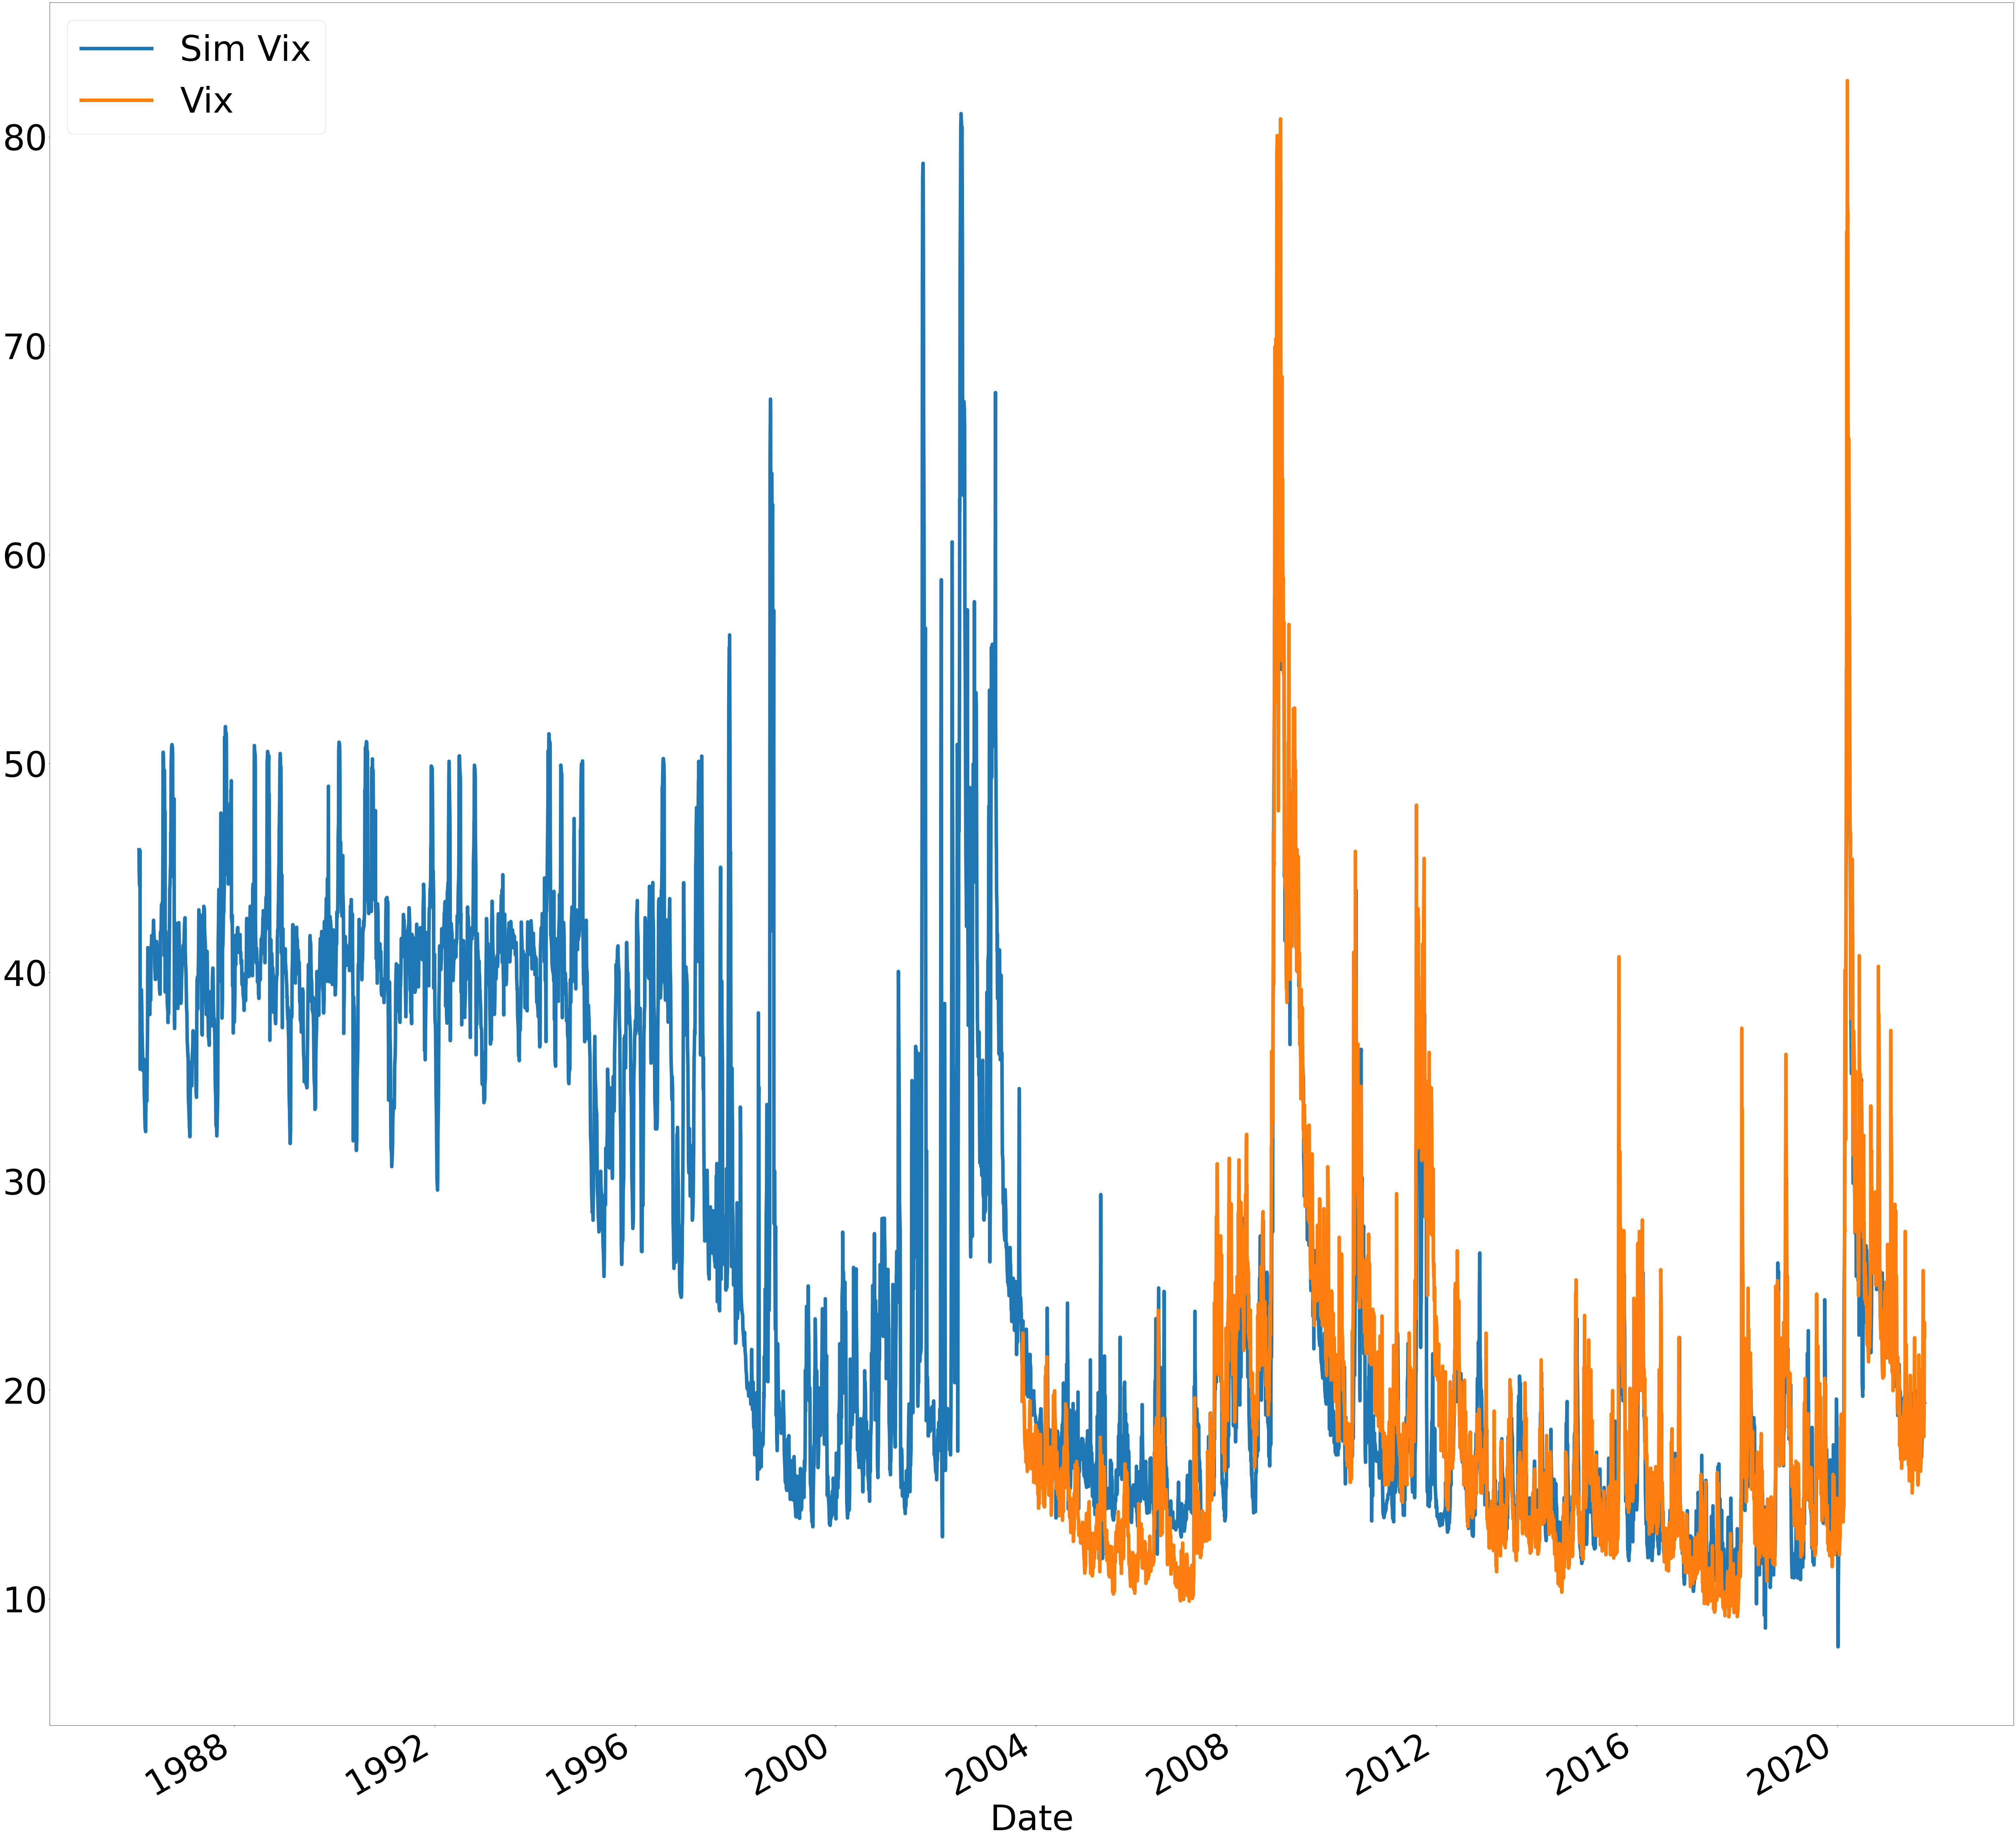

In [313]:
plt.figure()
plt.rcParams.update({'font.size': 100})
df_comb["simVix"].plot(legend=True, label="Sim Vix", figsize=(100,100), lw=10)
(df_vix_real["Close"]*100).plot(legend=True, label="Vix", figsize=(100,100), lw=10)


In [315]:
df_comb["simVix"].to_csv("tempVIX.csv")